In [164]:
from IPython.display import Markdown
from graphviz import Digraph, Graph

# class ComputeGraph:
#     def __init__(self):
#         self.graph = []


# https://en.wikipedia.org/wiki/Genetic_programming#Program_representation


COLORS = ["lightgrey", "pink", "lightgreen", "cyan"]


class Tree:
    def __init__(self, value, left_tree = None, right_tree = None, comment = None):
        self.value = value # unclear if necessary
        self.left_tree = left_tree
        self.right_tree = right_tree
        self.comment = comment
        
    def __add__(self, obj):
        if type(obj) == int or type(obj) == float:
            return Operation("+", self, Scalar(obj))
        else:
            return Operation("+", self, obj)
        
    def __sub__(self, obj):
        if type(obj) == int or type(obj) == float:
            return Operation("-", self, Scalar(obj))
        else:
            return Operation("-", self, obj)
        
    def __mul__(self, obj):
        if type(obj) == int or type(obj) == float:
            return Operation("*", self, Scalar(obj))
        else:
            return Operation("*", self, obj)
        
    def __truediv__(self, obj): 
        if type(obj) == int or type(obj) == float:
            return Operation("/", self, Scalar(obj))
        else:
            return Operation("/", self, obj)
        
    def __neg__(self):
        return Operation("-", Scalar(0), self)
    
    def __lshift__(self, obj):
        self.comment = obj
        return self
    
    def is_leaf(self):
        if isinstance(self, Operation):
            return False
        elif isinstance(self, Scalar):
            return True
        elif isinstance(self, Reference):
            return True
    
    def node(self, dot):
        color = None
        fillcolor = None
        style = None
        fontcolor = None
        if isinstance(self, Operation):
            color = "blue"
        elif isinstance(self, Stock):
            style = "filled"
            fillcolor = "orange"
        elif isinstance(self, Flow):
            style = "filled"
            fillcolor = "purple"
            fontcolor = "white"
        elif isinstance(self, Variable):
            style = "filled"
            fillcolor = "green"
            fontcolor = "white"
            
        dot.node(name=str(id(self)), label=str(self.value), color=color, fillcolor=fillcolor, style=style, fontcolor=fontcolor)
    
    def visualize(self, dot=None, comments=False, comment_colors_used=[]):
        if dot is None:
            dot = Digraph()
            
        # g = dot
        
        # TODO: it would be convenient if it was possible to only draw the comment block around leaves and parent, I need to figure out a way to define the boundaries that a comment actually applies to. 
        
        if comments and self.comment is not None:
            sub_color = None
            for color in COLORS:
                if color not in comment_colors_used:
                    sub_color = color
                    break
            if sub_color is None:
                comment_colors_used = []
                sub_color = COLORS[0]
            comment_colors_used.append(sub_color)
            
            with dot.subgraph(name=f"cluster_commented{id(self)}", body=["style=filled\n", f"fillcolor={sub_color}\n", f"label=\"{self.comment}\"\n", "labelloc=b\n"]) as g:
                
                self._visualize_inner(g, comments, comment_colors_used)
                
#                 self.node(g)

#                 if self.left_tree:
#                     g.edge(str(id(self.left_tree)), str(id(self)))
#                     g = self.left_tree.visualize(g, comments, comment_colors_used)

#                 if self.right_tree:
#                     g.edge(str(id(self.right_tree)), str(id(self)))
#                     g = self.right_tree.visualize(g, comments, comment_colors_used)
            
        else:
            self._visualize_inner(dot, comments, comment_colors_used)
#             self.node(dot)

#             if self.left_tree:
#                 dot.edge(str(id(self.left_tree)), str(id(self)))
#                 dot = self.left_tree.visualize(dot)

#             if self.right_tree:
#                 dot.edge(str(id(self.right_tree)), str(id(self)))
#                 dot = self.right_tree.visualize(dot)
            
        return dot

    def _visualize_inner(self, g, comments, comment_colors_used):
        self.node(g)

        if self.left_tree:
            g.edge(str(id(self.left_tree)), str(id(self)))
            g = self.left_tree.visualize(g, comments, comment_colors_used)

        if self.right_tree:
            g.edge(str(id(self.right_tree)), str(id(self)))
            g = self.right_tree.visualize(g, comments, comment_colors_used)
            
        return g
    
            
        
    
class Operation(Tree):
    def __init__(self, op, left_tree = None, right_tree = None):
        self.op = op
        super().__init__(op, left_tree, right_tree, None)
        
    def __repr__(self):
        return f"({self.op} {self.left_tree.__repr__()} {self.right_tree.__repr__()})"
    
    def latex(self, annotations=False): #recursive
        return Markdown(f"${self.latex_str(annotations)}$")
        
    def latex_str(self, annotations=False, top=False):
        if annotations and self.comment is not None:
            top = not top
            
        latex_left = self.left_tree.latex_str(annotations, top) if self.left_tree is not None else ""
        latex_right = self.right_tree.latex_str(annotations, top) if self.right_tree is not None else ""
        if self.right_tree is not None and isinstance(self.right_tree, Scalar) and self.right_tree.scalar == 0:
            latex_right = "0"
        
            
        core = ""
        if self.op == "+":
            core = f"{latex_left}+{latex_right}"
        elif self.op == "-":
            core = f"{latex_left}-{latex_right}"
        elif self.op == "*":
            core = f"{latex_left}*{latex_right}"
        elif self.op == "/":
            core = f"\\frac{{{latex_left}}}{{{latex_right}}}"
        elif self.op == "max":
            core = f"\sf{{max}}({latex_left}, {latex_right})"
        elif self.op == "min":
            core = f"\sf{{min}}({latex_left}, {latex_right})"
            
        if annotations and self.comment is not None:
            if top:
                core = f"\\overbrace{{{core}}}^{{\\texttt{{{self.comment}}}}}"
            else:
                core = f"\\underbrace{{{core}}}_{{\\texttt{{{self.comment}}}}}"
            
            
        return core
            
        
        
        
class Scalar(Tree):
    def __init__(self, scalar):
        self.scalar = scalar
        super().__init__(scalar, None, None, None)
        
    def __repr__(self):
        return str(self.scalar)
    
    def __eq__(self, obj):
        if not isinstance(obj, Scalar):
            return False
        return self.scalar == obj.scalar
    
    def latex_str(self, annotations=False, top=False):
        if self.scalar == 0:  
            return "" # so that negated vals don't always show a 0-
        else:
            return str(self.scalar)
    

class Reference(Tree):
    """A reference to a flow, stock, or variable."""
    def __init__(self, name):
        self.name = name
        self.latex_shorthand = ""
        self.description = "" # different from comment?
        super().__init__(name, None, None, None)
        
    def __repr__(self):
        return f"\"{self.name}\""
        
    def latex_str(self, annotations=False, top=False):
        return f"\\mathit{{{self.name}}}"
        pass
        
        
        
class Stock(Reference):
    """Implicit 'dt', must always keep backup of last val"""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        

        
class Flow(Reference):
    """Flows must be calculated first. Using a flow in a formula means using 'this timestep's value', unlike stocks."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        

class Variable(Reference):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

$\mathit{test}$

In [112]:
-Scalar(4)

(- 0 4)

In [113]:
Scalar(5) + Scalar(4) / Reference("groundwater")

(+ 5 (/ 4 "groundwater"))

In [114]:
(Scalar(5) + Scalar(4)) / Reference("groundwater")

(/ (+ 5 4) "groundwater")

In [115]:
(Scalar(5) + Scalar(4) / Reference("groundwater")).latex()

$5+\frac{4}{\mathit{groundwater}}$

In [116]:
(Scalar(5) + Scalar(4) / Stock(name="groundwater")).latex()

$5+\frac{4}{\mathit{groundwater}}$

In [117]:
((Scalar(5) + Scalar(4)) / Reference("groundwater")).latex()

$\frac{5+4}{\mathit{groundwater}}$

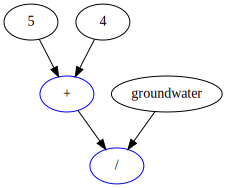

In [118]:
((Scalar(5) + Scalar(4)) / Reference("groundwater")).visualize()

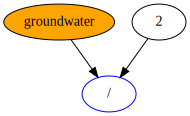

In [119]:
(Stock(name="groundwater") / 2).visualize()

In [120]:
t = Stock(name="groundwater") / 2                        << ("YO! This is a comment!", True)
t = t * (Scalar(6) + Scalar(8) << "random math")         << "This is just stuff"
t

(* (/ "groundwater" 2) (+ 6 8))

In [121]:
t.comment

'This is just stuff'

In [122]:
print(t.visualize(comments=True))

digraph {
	subgraph cluster_commented139670382244912 {
	style=filled
	fillcolor=lightgrey
	label="This is just stuff"
	labelloc=b
		139670382244912 [label="*" color=blue]
		139670382232624 -> 139670382244912
		subgraph cluster_commented139670382232624 {
		style=filled
		fillcolor=pink
		label="('YO! This is a comment!', True)"
		labelloc=b
			139670382232624 [label="/" color=blue]
			139670382240352 -> 139670382232624
			139670382240352 [label=groundwater fillcolor=orange style=filled]
			139670382237088 -> 139670382232624
			139670382237088 [label=2]
		}
		139670382241168 -> 139670382244912
		subgraph cluster_commented139670382241168 {
		style=filled
		fillcolor=lightgreen
		label="random math"
		labelloc=b
			139670382241168 [label="+" color=blue]
			139670374097120 -> 139670382241168
			139670374097120 [label=6]
			139670382241360 -> 139670382241168
			139670382241360 [label=8]
		}
	}
}



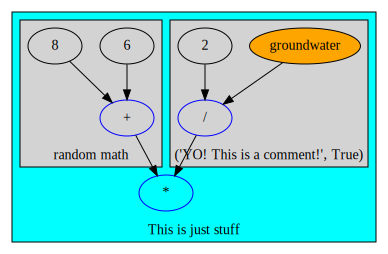

In [123]:
t.visualize(comments=True)

In [124]:
t.latex(annotations=True)

$\overbrace{\underbrace{\frac{\mathit{groundwater}}{2}}_{\texttt{('YO! This is a comment!', True)}}*\underbrace{6+8}_{\texttt{random math}}}^{\texttt{This is just stuff}}$

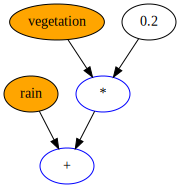

In [125]:
rain = Stock(name="rain")
rain = rain + Stock(name="vegetation") * 0.2
rain.visualize()

In [126]:
from ipywidgets import HBox, Output, VBox
from IPython.display import display

def cols(*things):
    displays = []
    for thing in things:
        out = Output()
        with out:
            display(thing)
        displays.append(out)
        
    return HBox(displays)

def rows(*things):
    displays = []
    for thing in things:
        out = Output()
        with out:
            display(thing)
        displays.append(out)
        
    return VBox(displays)

In [127]:
# It would be convenient if we could "query" a tree for an operation in order to manually add a comment after the fact, so we don't have to rely on jank.

In [147]:
rain

(- (+ (* "vegetation" 0.2) 14) "runoff")

In [128]:
# comments can be added with <<
rain = Stock(name="vegetation") * 0.2    << "Evaporation from plants"
rain = rain + 14                         << "A base rate amount of rain, or something"
rain = rain - Flow(name="runoff")        << "Some of it drains away"

# alternative version without "comments"
rain_single = Stock(name="vegetation") * 0.2 + 14 - Flow(name="runoff")

cols(rain.visualize(), rain.visualize(comments=True), rain_single.latex())

In [129]:
rain.latex(annotations=True)

$\overbrace{\underbrace{\overbrace{\mathit{vegetation}*0.2}^{\texttt{Evaporation from plants}}+14}_{\texttt{A base rate amount of rain, or something}}-\mathit{runoff}}^{\texttt{Some of it drains away}}$

In [130]:
rain3 = (Stock("vegetation") * 0.2 << "Evaporation from plants") \
    + (Scalar(14)                           << "A base rate of rain") \
    - Flow("runoff")

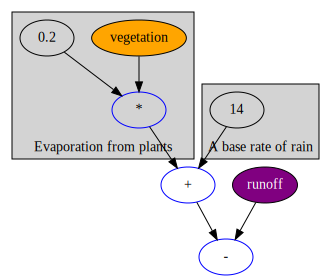

In [131]:
rain3.visualize(comments=True)

In [132]:
rain3.latex(annotations=True)

$\overbrace{\mathit{vegetation}*0.2}^{\texttt{Evaporation from plants}}+14-\mathit{runoff}$

$$
1 + \overbrace{3}^{\texttt{this is all just a test}}
$$

In [133]:
(Stock(name="vegetation") * 0.2 + 14 - Flow(name="runoff")).latex()

$\mathit{vegetation}*0.2+14-\mathit{runoff}$

In [134]:
(Scalar(1) + Stock(name="vegetation") * 0.2).latex_str()

'1+\\mathit{vegetation}*0.2'

In [135]:
(Stock(name="vegetation") * 5).latex_str()

'\\mathit{vegetation}*5'

In [136]:
L = Stock
R = Flow

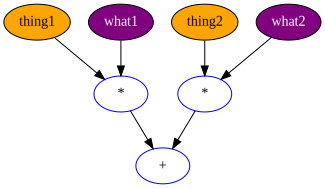

In [137]:
t = L("thing1") * R("what1") + L("thing2") * R("what2")
t.visualize()

In [138]:
class Model(object):
    def __init__(self):
        self.components = {}
        self.delta_trees = {}
        
    # actually, as long as operations return a new thing, this should just work.
    def __setattr__(self, name, value):
        #if isinstance(value, Tree):
        if isinstance(value, Tree):
            if name not in self.components:
                self.components[name] = value
                self.delta_trees[name] = None # don't include self in delta tree (implicit add)
            else:
                # don't actually overwrite, this is returnning a compute graph
                if self.delta_trees[name] is None:
                    self.delta_trees[name] = value
                else:
                    self.delta_trees[name] = self.delta_trees[name] + value
                # TODO: we need the operations to also return a non-compute system symbolic graph? Or can this always be inferred from the compute graph and the list of names/stocks/flows we have in model?
                # the latter. We just need to find all reference nodes, and that means there's an edge from that reference node _to_ the current node.

                # this also means you can define the formula for a value in pieces, and it will assume you're adding them all together. (this also allows documenting specific portions)
        else:
            object.__setattr__(self, name, value)
            
    def __getattr__(self, name):
        if name in self.components:
            return self.components[name]
            
            
    def _compile(self):
        """Write optimized jax operation list for computations into python file?"""
        pass

**Stocks** are solely defined in terms of flows

In [153]:
class Ops:
    @staticmethod
    def Max(t1: Tree, t2: Tree):
        return Operation("max", t1, t2)
    def Min(t1: Tree, t2: Tree):
        return Operation("min", t1, t2)

In [169]:
S = Stock
F = Flow
V = Variable

In [170]:
m = Model()

m.cloudwater = S("cloudwater")
m.groundwater = S("groundwater")
m.vegetation = S("vegetation")
m.runoff = S("runoff")

# for each of these, if we do not define a formula for them, they are "free variables"
m.evaporation = F("evaporation")
m.rain = F("rain")
m.groundwater_usage = F("groundwater usage")
m.runoff_dispersion = F("runoff dispersion")
m.runoff_spill = F("runoff spill")
m.runoff_cleanup = F("runoff cleanup") << "the rate at which runoff is cleaned by excess vegetation"

m.rain_base_rate = V("rain base rate")

m.evaporation = m.vegetation * 0.2 + m.groundwater * 0.05
m.groundwater_usage = m.vegetation * 0.5 
m.rain = m.cloudwater * 0.4 + m.rain_base_rate
m.runoff_spill = Ops.Max(m.groundwater - m.vegetation, Scalar(0)) << "Any more groundwater than plants to support it is runoff"
m.runoff_cleanup = Ops.Max((m.vegetation - m.groundwater), Scalar(0)) * 0.02


m.cloudwater = Ops.Max(m.evaporation + m.rain_base_rate - m.rain, Scalar(0))  << "min constraint: 0"
m.groundwater = Ops.Max(m.rain - m.evaporation, Scalar(0))                    << "min constraint: 0"
m.vegetation = m.groundwater_usage
m.runoff = m.runoff_spill - m.runoff_dispersion
#m.vegetation = 


In [171]:
m.delta_trees

{'cloudwater': (max (- (+ "evaporation" "rain base rate") "rain") 0),
 'groundwater': (max (- "rain" "evaporation") 0),
 'vegetation': "groundwater usage",
 'runoff': (+ "runoff" "groundwater"),
 'evaporation': (+ (* "vegetation" 0.2) (* "groundwater" 0.05)),
 'rain': (+ (* "cloudwater" 0.4) "rain base rate"),
 'groundwater_usage': (* "vegetation" 0.5),
 'runoff_dispersion': None,
 'runoff_spill': None,
 'rain_base_rate': None}

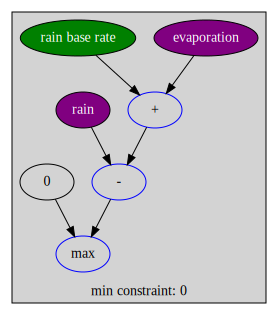

In [172]:
m.delta_trees["cloudwater"].visualize(comments=True)

In [173]:
m.delta_trees["cloudwater"].latex()

$\sf{max}(\mathit{evaporation}+\mathit{rain base rate}-\mathit{rain}, 0)$

"clouds"

In [ ]:





m = Model()

m.clouds = Stock()
m.groundwater = Stock()
m.food = Stock()

m.food = (m.clouds + 3) * m.groundwater # an implicit flow?





In [ ]:
# how do we model moving values from one stock to another?


# involves one stock starting with an initial value, a flow, and another stock.

m = Model()
m.from_stock = Stock()     << "some other comment?"
m.to_stock = Stock()
m.movement_flow = Flow()


#m.flow(from_stock, to_stock, m.from_stock / 2)
#m.to_stock <= m.from_stock / 2 # I think beyond simple cases it's too hard to imply what it's actually being removed "from"

# a flow implies things leaving one stock and entering another.


# way too verbose
m.to_stock[m.t+1] = m.to_stock[m.t] + m.from_stock[m.t] / 2
m.from_stock[m.t+1] = m.to_stock[m.t] + m.from_stock[m.t] / 2

# more obvious directionality, but dislike
m.movement_flow <= m.from_stock / 2
m.to_stock <= m.movement_flow

# from https://en.wikipedia.org/wiki/Stock_and_flow
# "stock" = "level"
# "flow" = "rate"
# I prefer their "order of execution" translation formulas.
# -----------------------------------
m.movement_flow = m.from_stock / 2
m.from_stock -= m.movement_flow
m.to_stock += m.movement_flow
# -----------------------------------
# or (technically the more integral-y form, an implicit 'dt')
# -----------------------------------
m.movement_flow = m.from_stock / 2    << "this is a test"                               # two nodes: "from_stock" "/ 2"
m.from_stock = -m.movement_flow       << "We move out of from stock"
m.to_stock = m.movement_flow          << "And into the to stock"
# -----------------------------------
# then we can set initial conditions by overriding __getitem__:
m.from_stock[0] = 10 # if we want to hold it static?




In [ ]:
# how do we manage probabilistic events?

m.groundwater_capacity = Variable()
m.groundwater = Stock()
m.fire = Event()
m.fire.P = .01 + 1 / (m.groundwater_capacity - m.groundwater)